In [1]:
import pandas as pd
import ast
import statistics
import matplotlib.pyplot as plt
import numpy as np
import tables
import seaborn as sns
from scipy.interpolate import UnivariateSpline
from scipy.stats import spearmanr
from nltk.corpus import cmudict
import nltk.corpus.reader.cmudict
from string import digits
from collections import defaultdict
import re
from scipy.interpolate import make_interp_spline, BSpline
from intersection_imagenet_flickr8k import imagenet_flickr8k_intersection,intersection


In [2]:
def interp1d(a,dim):
    old_indices = np.arange(0,len(a))
    new_length = dim
    new_indices = np.linspace(0,len(a)-1,new_length)
    spl = UnivariateSpline(old_indices,a,k=1,s=0)
    new_array = spl(new_indices)
    return new_array

def make_phoneme_dictionary(worddict):
    #make sure to intialize the corpus outside of the function
    for word,value in worddict.items():
        remove_digits = str.maketrans('', '', digits)
        try:
            x = [words.translate(remove_digits) for words in arpabet[word][0]]
            testsetdictionary[word] = x
        except:
            continue
            
def make_markus_phoneme_dictionary(worddict):
    #make sure to intialize the corpus outside of the function
    for word,value in worddict.items():
        try:
            x = markusdictionary[word][0]
            testsetdictionary[word] = x
        except:
            continue
def replaceMultiple(mainstring, replacelist, replacevalue):
    # Iterate over the strings to be replaced
    for elem in replacelist :
        # Check if string is in the main string
        if elem in mainstring :
            # Replace the string
            mainstring = mainstring.replace(elem, replacevalue)
    
    return  mainstring

def double_plot_line(scores,scoresreverse,xticks,xreverseticks,xlabel="Phonemes shown",ylabel="Precision@10",title = "Average scores for amount of phonemes shown from left-to-right and right-to-left"):

    plt.style.use('seaborn-deep')
    x_new = np.linspace(1, 9, 40)
    plt.tight_layout()

    fig, ax = plt.subplots()

    plt.plot(xticks,scoresreverse,color="y",label="right-to-left",marker='s', markeredgecolor='black')
    plt.plot(xticks,scores,color="#083370", label="left-to-right",marker='s', markeredgecolor='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.legend()
    plt.show()
    
def make_heatmap(path):
    df = pd.read_csv(path)

    testlist = ["dog","man","boy","girl","woman","people"
                ,"dogs","shirt","child","ball","person"
                ,"children","men","girls","bike","rock","camera"
                ,"boys","hat","player","jacket","basketball","swing"
                ,"car", "wall", "hair","football","sunglasses","head"
                ,"shorts","dress","table","water","grass","bench","snow"
                ,"air","field","street","mouth","dirt","mountain","pool"
                ,"ocean","sand","building","soccer","park","face"]

    df["Testedword"] = df["Tested"].str.replace("flickr_","")
    df["Testedword"] = [words.split("_")[2] for words in df["Testedword"]]
    df["Results"] = [ast.literal_eval(score) for score in df["Results"]]
    df["Precision@10"] = [sum(score)*0.1 for score in df["Results"]]
    df["AmntPhonemes"] = [int(words.split("_")[1]) for words in df["Tested"]]

    scorelist = pd.DataFrame()
    for i in range(1,max(df["AmntPhonemes"])+1):
        averagescore = sum(df[df["AmntPhonemes"] == i]["Precision@10"])/len(df[df["AmntPhonemes"] == i])
        valuesdict = {"Amntphonemes": i,"Nphonemes":len(df[df["AmntPhonemes"] == i]), "Avgscore": averagescore}
        scorelist = scorelist.append(valuesdict, ignore_index=True)

    header_list = ["Word","1","2","3","4","5","6","7","8","9"]
    df1 = pd.DataFrame()
    df1["Word"] = [word for word in testlist]
    df1 = df1.reindex(columns = header_list)

    dfheatmap = pd.DataFrame()

    for idx,word in enumerate(df1["Word"]):
        subdf = df[df["Testedword"] == word]
        for i in range(1,max(subdf["AmntPhonemes"])+1):
            averagescore = sum(subdf[subdf["AmntPhonemes"] == i]["Precision@10"])/len(subdf[subdf["AmntPhonemes"] == i])
            valuesdict = {"Words": word, "Percentage shown": i, "AvgScore": averagescore}
            dfheatmap = dfheatmap.append(valuesdict, ignore_index=True)
            df1[f"{i}"].iloc[idx] = averagescore

    df1["Naan"] = df1.isnull().sum(axis=1)
    df1 = df1.sort_values(by=["Naan"])
    custom_order = list(df1["Word"])

    worddict = pd.DataFrame(columns = ["Word","Score"])
    df2 = df1.drop("Naan",axis=1)
    for idx,rows in enumerate(df2["Word"]):
        worddict = worddict.append({"Word":rows,"Score":df2.iloc[idx][1:].sum()},ignore_index=True)
    bestscorelist = list(worddict.sort_values("Score",ascending = False)["Word"])

    testheatmap = dfheatmap
    dfheatmap = dfheatmap.pivot(index="Words",columns="Percentage shown",values="AvgScore")
    dfheatmap = dfheatmap.reindex(custom_order, axis=0)

    for word in testlist:
        testheatmap.loc[testheatmap["Words"] == word,"AvgScore"] = testheatmap[testheatmap["Words"] == word]["AvgScore"]/(testheatmap["AvgScore"][testheatmap[testheatmap["Words"] == word]["AvgScore"].idxmax()])

    dfheatmap.to_csv("manual.csv")
    dfheatmapimport = pd.read_csv("wordactivationheatmapduplicatefill.csv",index_col=0,sep=";")
    dfheatmapimport.columns.name = "Percentage of phonemes shown"
    dfheatmap = dfheatmapimport.reindex(bestscorelist, axis=0)
    
    plt.figure(figsize=(10, 12))
    xticks = ["10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"]
    
    
    plt.style.use('seaborn-poster')

    ax = sns.heatmap(dfheatmap,cmap="viridis",xticklabels=xticks, yticklabels=True,linewidths=0,cbar_kws={'label': 'Precision@10'})
    # ax = sns.heatmap(dfheatmap,cmap="YlOrRd",xticklabels=True, yticklabels=True,linewidths=0,cbar_kws={'label': 'Precision@10'})

#     ax.set_title('Precision@10 scores for percentage of word shown',fontsize=20,pad=20)
    plt.tight_layout()

    plt.savefig('/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/plots/phonemeheatmap_cut.png',dpi=400)

    plt.show()
    
    dfinterpolated = pd.DataFrame(dfheatmap)
    dfinterpolated["10"] = np.nan
    for i in range(len(dfinterpolated)):
        sequence = list(dfinterpolated.iloc[i,:])
        sequence = [x for x in sequence if str(x) != 'nan']
        sequence = np.array(sequence)
        interpsequence = interp1d(sequence,10)
        dfinterpolated.iloc[i] = interpsequence
        
    return df1,dfinterpolated

/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


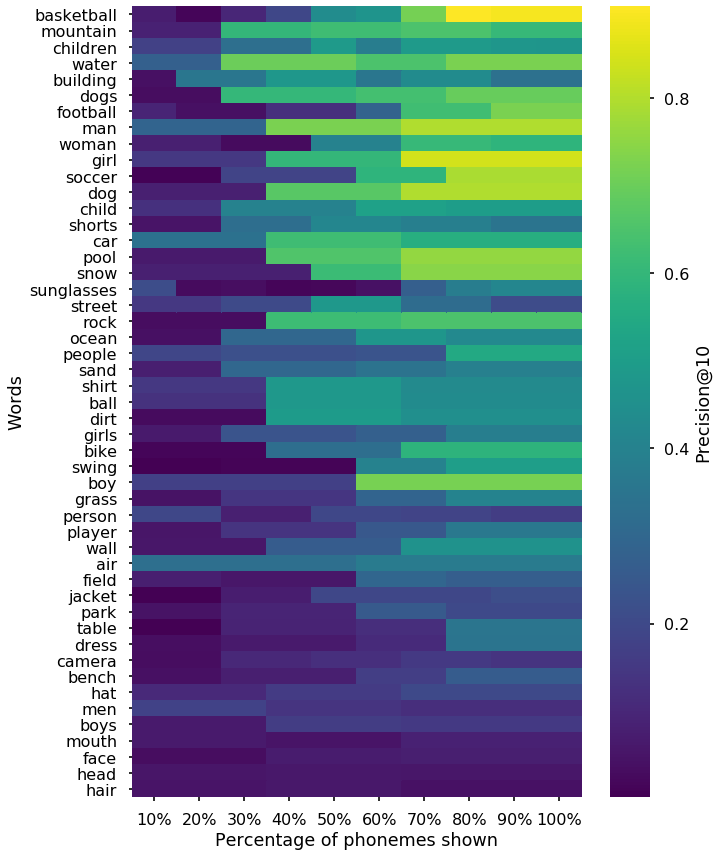

In [3]:
path = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/Results_isolated_word_recognition/results_forcedalignment_phonemes49words.csv"
df1,dfinterpolated1 = make_heatmap(path)

/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


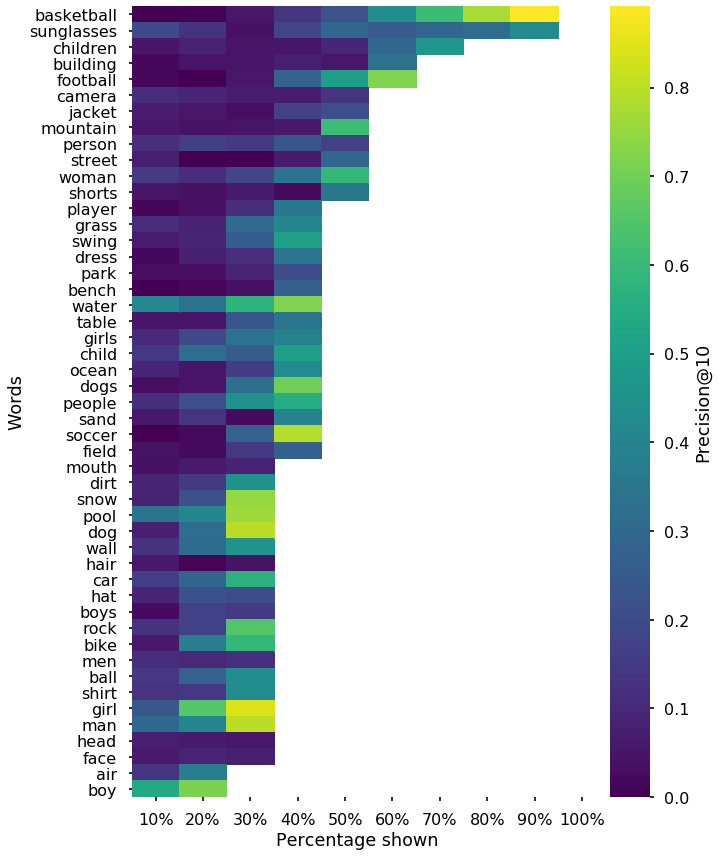

In [4]:
path = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/Results_isolated_word_recognition/results_forcedalignment_phonemes49words_reverse.csv"
df2,dfinterpolated2 = make_heatmap(path)


In [5]:
# interpolatedscores = []
# for column in dfinterpolated1[1.0].sum()/len(dfinterpolated1[1.0])

<Figure size 921.6x633.6 with 0 Axes>

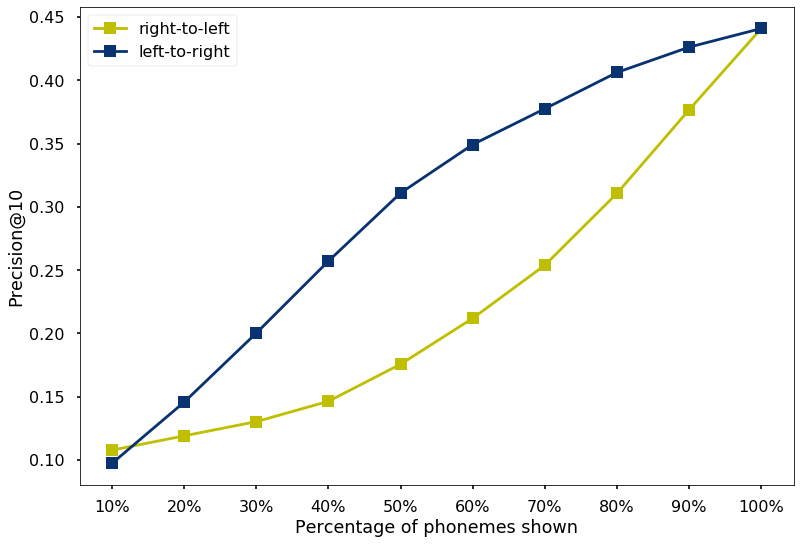

In [6]:
xticks = ["10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"]
scoresinterpolated = []
scoresreverseinterpolated = []
for column in dfinterpolated1:
    scoresinterpolated.append(dfinterpolated1[column].sum()/len(dfinterpolated1[column]))
    
for column in dfinterpolated2:
    scoresreverseinterpolated.append(dfinterpolated2[column].sum()/len(dfinterpolated2[column]))
scoresreverseinterpolated[-1] = scoresinterpolated[-1]
double_plot_line(scoresinterpolated,scoresreverseinterpolated,xticks,xticks,
                 title="",xlabel = "Percentage of phonemes shown")


In [8]:
# scores = []
# df1 = df1.drop("Naan",axis=1)
# for column in df1.columns[1:]:
#     scores.append(sum(df1[column].fillna(0))/(len(df1[column])-sum(df1[column].isna())))

In [9]:
xreverseticks

NameError: name 'xreverseticks' is not defined

<Figure size 921.6x633.6 with 0 Axes>

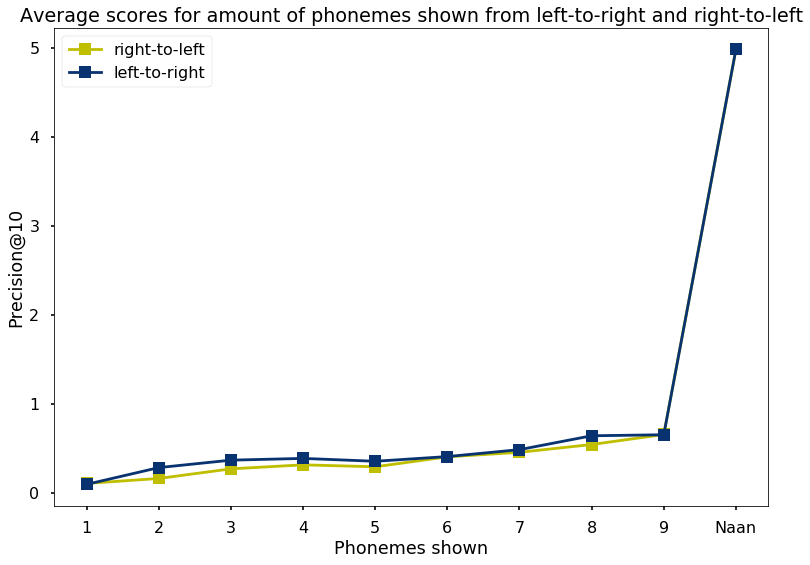

In [10]:
scores = []
scoresreverse = []

# df1 = df1.drop("Naan",axis=1)
# df2 = df2.drop("Naan",axis=1)

for column in df1.columns[1:]:
    scores.append(sum(df1[column].fillna(0))/(len(df1[column])-sum(df1[column].isna())))
for column in df2.columns[1:]:
    scoresreverse.append(sum(df2[column].fillna(0))/(len(df2[column])-sum(df2[column].isna())))
xticks = list(df1.columns[1:])
xreverseticks = list(df2.columns[1:])
double_plot_line(scores,scoresreverse,xticks,xreverseticks)

In [11]:
path = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/Results_isolated_word_recognition/results_forcedalignment_phonemes49words.csv"
df = pd.read_csv(path)

df["Testedword"] = df["Tested"].str.replace("flickr_","")
df["Testedword"] = [words.split("_")[2] for words in df["Testedword"]]


df["Results"] = [ast.literal_eval(score) for score in df["Results"]]
df["Precision@10"] = [sum(score)*0.1 for score in df["Results"]]
df["AmntPhonemes"] = [int(words.split("_")[1]) for words in df["Tested"]]

In [12]:
df["Phoneme"] = np.nan

for idx,word in enumerate(df["Tested"]):
    df["Phoneme"][idx] = word.split("_",-1)[2]
    
    

/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
import json
from nltk.tokenize import RegexpTokenizer
path = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/data/Flickr8k_text/Flickr8k.token.txt"
path2 = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/data/dataset.json"
file = json.load(open(path2))
split_dict = {}
for x in file['images']:
    split_dict[x['filename'].replace('.jpg', '')] = x['split']
trainingset = []
for key, value in split_dict.items():
    if value == "train":
        trainingset.append(key)
text = pd.read_csv(path, sep="\t",header=None)
text.columns = ["images","captions"]
textcopy = text
text.images = [words[:-6] for words in text.images if words==words]
# use this if you only want to use text in testset
text = text[text.images.isin(trainingset)]

text = text["captions"]
tokenizer = RegexpTokenizer(r'\w+')
wordlist = []
for sentence in text:
    sentence = sentence.lower()
    words = tokenizer.tokenize(sentence)
    wordlist.extend(words)
wordlist = [x.lower() for x in wordlist]
sr = pd.Series(wordlist)
worddictionary = dict(sr.value_counts())



In [14]:
markusdictionary

NameError: name 'markusdictionary' is not defined

In [21]:
#creating the dictionary from Markus's file

file = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/data/flickr8.dict.txt"
markusdictionary = defaultdict(list)
with open(file, "r") as f:
    for line in f:
        #check if the word ends with - otherwise just take out first string and lower()
        if line.split(" ",-1)[0].lower()[-1] == "-":
            word = line.split(" ",-1)[0].lower()[:-1]
        elif line.split(" ",-1)[0].lower()[-1] == ")":
            word = re.sub(r'\(([^)]+)\)', '', line.split(" ",-1)[0].lower())
        else:
            word = line.split(" ",-1)[0].lower()
        #parse out unneeded information
        phonemes = replaceMultiple(line, ["\n","{","}","WB"], "")
        phonemes = re.sub(' +', ' ', phonemes)[:-1]
        phonemes = phonemes.split(" ")[1:]
        
        markusdictionary[word].append(phonemes)
#to remove list in list duplicates
for key, value in markusdictionary.items():
    b_set = set(tuple(x) for x in value)
    b = [ list(x) for x in b_set ]
    markusdictionary[key] = b
    
arpabet = nltk.corpus.cmudict.dict()
testsetdictionary = {}

make_markus_phoneme_dictionary(worddictionary)

wordlists= []
for key, value in testsetdictionary.items():
    for values in value:
        wordlists.append(values)
myset = set(wordlists)
allmarkus = list(myset)
allmarkus.sort(key=len,reverse=True)

#start calculating word initial cohort
phonemedict = defaultdict(list)

for word, phonemes in testsetdictionary.items():
    count = 0
    for idx,phoneme in enumerate(phonemes):
            phonemedict["".join(phonemes[:idx+1])].append(word)
        

phonemedictword = defaultdict(list)

for word, phonemes in testsetdictionary.items():
    count = 0
    phonemedictword["".join(phonemes)].append(word)
df["wordcohort"] = np.nan
for idx,phoneme in enumerate(df["Phoneme"]):
    df["wordcohort"][idx] = len(phonemedict[phoneme])
    

#calculate one-phoneme substitution
df["neighbourhooddensity"] = np.nan

for idx,word in enumerate(df["Testedword"]):
    p = markusdictionary[word][0].copy()
    ndens = 0
    plist = df["Phoneme"][idx]
    
    for idx3,ph in enumerate(p):
        if plist == "".join(p[:idx3+1]):
            p = p[:idx3+1]
    
    
    for idx2,phones in enumerate(p):
        for phonelist in allmarkus:
            phonecopy = p.copy()
            phonecopy[idx2] = phonelist
            phonejoin = "".join(phonecopy)
            ndens = ndens + len(phonemedictword[phonejoin])
            
    df["neighbourhooddensity"][idx] = ndens

dfspkid = pd.read_csv("/Users/sebastiaanscholten/Downloads/rfilecsv.csv")
df["spk_id"] = np.nan
for idx,files in enumerate(df["Tested"]):
    x = files.split("_",-1)[4:7]
    y = "_".join(x)
    for idx2,comparefiles in enumerate(dfspkid["WordInstance"]):
        if y == comparefiles:
            df["spk_id"][idx] = int(dfspkid["spk_id"][idx2])
            break
            
df["TrainingSetOccurence"] = [worddictionary[word] for word in df["Testedword"]]
df["wordid"] = df.groupby("Testedword").grouper.group_info[0]

imagenet_flickr8k_words = imagenet_flickr8k_intersection()

df["inimagenet"] = np.nan

for idx,word in enumerate(df["Testedword"]):
    if word in imagenet_flickr8k_words:
        df["inimagenet"][idx] = "1"
        continue
    df["inimagenet"][idx] = "0"
    
df.to_csv("phonemedata.csv",index=False)

/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [15]:
wordsandphonemesequence = pd.DataFrame(columns=["Word","Phoneme Sequence"])

In [16]:
for word in testlist:
    wordsandphonemesequence = wordsandphonemesequence.append({"Word":word,"Phoneme Sequence":markusdictionary[word][0]},ignore_index=True)

In [17]:
wordsandphonemesequence.to_csv("../data/wordsandphonemesequences.csv",sep=",")

In [23]:
len(markusdictionary)

75200

In [5]:
# x,p=spearmanr(df["Precision@10"],df["wordcohort"])
# x1,p1=spearmanr(df["Precision@10"],df["neighbourhooddensity"])
# x2,p2=spearmanr(df["Precision@10"],df["AmntPhonemes"])
# print(f"word initial cohort: coefficient: {x} pvalue: {p}")
# print(f"neighbourhood Density: coefficient: {x1} pvalue: {p1}")
# print(f"Amnt of of phonemes: coefficient: {x2} pvalue: {p2}")

In [9]:
# dfinterpolated = pd.DataFrame(dfheatmap)
# dfinterpolated["10"] = np.nan
# for i in range(len(dfinterpolated)):
#     sequence = list(dfinterpolated.iloc[i,:])
#     sequence = [x for x in sequence if str(x) != 'nan']
#     sequence = np.array(sequence)
#     interpsequence = interp1d(sequence,10)
#     dfinterpolated.iloc[i] = interpsequence

NameError: name 'dfheatmap' is not defined

In [ ]:
# testheatmap
# dfheatmap = testheatmap.pivot(index="Words",columns="Length of phoneme sequence shown",values="AvgScore")
# dfheatmap = dfheatmap.reindex(custom_order, axis=0)

# plt.figure(figsize=(10, 12))
# ax = sns.heatmap(dfheatmap,cmap="Blues",xticklabels=True, yticklabels=True,linewidths=0,cbar_kws={'label': 'sequence Precision@10 / highest sequence Precision@10'})
# # ax = sns.heatmap(dfheatmap,cmap="YlOrRd",xticklabels=True, yticklabels=True,linewidths=0,cbar_kws={'label': 'Precision@10'})
# ax.set_title('Image retrieval scores for all phoneme sequences')
# plt.savefig('/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/plots/phonemeheatmap_cut.png')

# plt.show()

In [10]:
# x_new = np.linspace(1, 9, 40)
# a_BSpline = make_interp_spline(xticks, scores)
# y_new = a_BSpline(x_new)

# plt.plot(x_new,y_new)
# plt.plot(xticks,scores)

NameError: name 'xticks' is not defined

In [15]:
markusdictionary

NameError: name 'markusdictionary' is not defined